In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
data = {
    "age" : [],
    "gender" : [],
    "race" : [],
    "date_time" : [],
    "file_name" : [],
}

directory_path = "./UTKFace/"

file_name = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
count = 0
for file in file_name:
    parts = file.split("_")
    if len(parts) != 4:
        continue
    try:
        data["age"].append(int(parts[0]))
        data["gender"].append(int(parts[1]))
        data["race"].append(int(parts[2]))
        data["date_time"].append((parts[3].split(".jpg.chip.jpg")[0]))
        data["file_name"].append(file)
        
    except ValueError:
        print(f"FILE {file} is Skipped")
        count = count + 1
        continue
        
        
df = pd.DataFrame(data)

In [10]:
df.shape

(23705, 5)

In [1]:
from IPython.display import HTML
HTML('<img src="./giphy1.gif">')

## Age Classification Model

### For Performing Multiclass classification

In [11]:
def categorize_age(age):
    if age <= 14:
        return "Children"
    elif age <= 24:
        return "Teenagers"
    elif age <= 35:
        return "Young Adults"
    elif age <= 59:
        return "Adults"
    else:
        return "Seniors"
    
df["age_category"] = df["age"].apply(categorize_age)    

In [12]:
df["age_category"].value_counts()

Young Adults    8204
Adults          5910
Children        3651
Teenagers       3252
Seniors         2688
Name: age_category, dtype: int64

In [13]:
df["age_category"].value_counts(normalize = True)*100

Young Adults    34.608732
Adults          24.931449
Children        15.401814
Teenagers       13.718625
Seniors         11.339380
Name: age_category, dtype: float64

* imbalanced classes
* seniors represents only 11% of the dataset size

In [14]:
from tensorflow.keras.utils import Sequence
import cv2

class DataGenerator(Sequence):
    def __init__(self, df, batch_size = 32, dim = (224,224), n_channels = 3, shuffle = True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.labels = df[["age_category_encoded", "race_encoded", "gender_encoded"]].values
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_IDs_temp = [self.df.iloc[k].file_name for k in indexes]
        
        list_labels_temp = self.labels[indexes]
        
        X, y = self.__data_generation(list_IDs_temp, list_labels_temp)
        
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self,list_IDs_temp, list_labels_temp):
        
        X = np.empty((self.batch_size, *self.dim, self.n_channels)) 
        y = np.empty((self.batch_size, ), dtype = int)
        
        for i, ID in enumerate(list_IDs_temp):
            
            img_path = os.path.join("./UTKFace", ID)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224,224))
            X[i, ] = img/255.0
            
            y[i] = list_labels_temp[i][0]
            
        return X, y

### Lossless compression
to create this encoding => age_category_encoded", "race_encoded", "gender_encoded

* To mantain the order we are going to make integer encoding rather than one hot encoding
* so we will be using sparse categorical Cross Entropy as loss function

In [15]:

age_mapping = {
    "Children" : 0,
    "Teenagers" : 1,
    "Young Adults" : 2,
    "Adults" : 3,
    "Seniors" : 4
}

race_mapping = {
    "White" : 0,
    "Black" : 1,
    "Asian" : 2,
    "Indian" : 3,
    "Others" : 4
}

gender_mapping = {
    "Male" : 0,
    "Female" : 1
}

reverse_age_mapping = {v:k for k,v in age_mapping.items()}
reverse_race_mapping = {v:k for k,v in race_mapping.items()}
reverse_gender_mapping = {v:k for k,v in gender_mapping.items()}

In [16]:
df["age_category_encoded"] = df["age_category"].map(age_mapping)
df["race_encoded"] = df["race"]
df["gender_encoded"] = df["gender"]

### for performing Train, Test and Validation we choosed

## Stratified Fold
to maintain the composition of the classes


#### 10,000 => 2000 (20%) cats , 8000 (80%) Dogs 

#### train and test split (70 and 30)


#### train(20% => cats && 80% => Dogs) == 1400 Cats && 5600 Dogs

#### test(20% => cats && 80% => Dogs) == 600 Cats && 2400 Dogs

* Here we are considering that our data shows the real world scenario

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

df.reset_index(drop = True, inplace = True)

stratified_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in stratified_split.split(df,df["age_category"]):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]
    
test_df.reset_index(drop = True, inplace  =True)

validation_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.5, random_state = 42)

for test_index, valid_index in validation_split.split(test_df, test_df["age_category"]):
    test_df_final = test_df.loc[test_index]
    valid_df = test_df.loc[valid_index]
    
    
train_generator = DataGenerator(df = train_df, batch_size = 32, dim = (224,224), n_channels = 3, shuffle = True)
valid_generator = DataGenerator(df = valid_df, batch_size = 32, dim = (224,224), n_channels = 3, shuffle = True)
test_generator = DataGenerator(df = test_df_final, batch_size = 32, dim = (224,224), n_channels = 3, shuffle = False)

In [18]:
df["age_category"].value_counts(normalize = True)*100

Young Adults    34.608732
Adults          24.931449
Children        15.401814
Teenagers       13.718625
Seniors         11.339380
Name: age_category, dtype: float64

In [19]:
train_df["age_category"].value_counts(normalize = True)*100

Young Adults    34.607678
Adults          24.931449
Children        15.402869
Teenagers       13.720734
Seniors         11.337271
Name: age_category, dtype: float64

In [20]:
valid_df["age_category"].value_counts(normalize = True)*100

Young Adults    34.626740
Adults          24.926191
Children        15.394348
Teenagers       13.707296
Seniors         11.345424
Name: age_category, dtype: float64

In [21]:
test_df_final["age_category"].value_counts(normalize = True)*100

Young Adults    34.599156
Adults          24.936709
Children        15.400844
Teenagers       13.713080
Seniors         11.350211
Name: age_category, dtype: float64

## Building Model

In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

* MobileNetV2 is a pre-trained convolutional neural network (CNN) model available in Keras with weights pre-trained on the ImageNet dataset.
* weights="imagenet" specifies that the model should be loaded with weights pre-trained on the ImageNet dataset.
* include_top=False indicates that the fully connected layers (top) of the MobileNetV2 model will be excluded, allowing for custom layers to be added.

In [20]:
base_model = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (224,224,3))

base_model.trainable = False # preventing weights from being updated during training
# helps to retain the pre-learned features

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(16, activation= "relu")(x)
x = Dense(16, activation= "relu")(x)
x = Dense(32, activation= "relu")(x)
x = Dense(64, activation= "relu")(x)
x = Dense(128, activation= "relu")(x)

num_age_categories = 5  # number of output categories for age prediction

predictions = Dense(num_age_categories, activation = "softmax")(x) # softmax : generates probabilities for each age category

model = Model(inputs = base_model.input, outputs = predictions)

model.compile(optimizer = Adam(learning_rate = 0.0001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

* custom layers learn to interpret the abstract features extracted by MobileNetV2 in the context of age prediction

## Look at various architectures like effiecient net (multiple versions), squeezenet (multiple versions), mobilenet (other versions) or any lightweight you can find.

### EfficientNet

In [18]:
from tensorflow.keras.applications import EfficientNetB0

In [19]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(16, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)

num_age_categories = 5  
predictions = Dense(num_age_categories, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]'] 

 y)                                                                  'block2a_se_expand[0][0]']   
                                                                                                  
 block2a_project_conv (Conv  (None, 56, 56, 24)           2304      ['block2a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block2a_project_bn (BatchN  (None, 56, 56, 24)           96        ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_expand_conv (Conv2  (None, 56, 56, 144)          3456      ['block2a_project_bn[0][0]']  
 D)                                                                                               
          

                                                                                                  
 block3a_project_conv (Conv  (None, 28, 28, 40)           5760      ['block3a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block3a_project_bn (BatchN  (None, 28, 28, 40)           160       ['block3a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_expand_conv (Conv2  (None, 28, 28, 240)          9600      ['block3a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block3b_e

 block4a_project_conv (Conv  (None, 14, 14, 80)           19200     ['block4a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block4a_project_bn (BatchN  (None, 14, 14, 80)           320       ['block4a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_expand_conv (Conv2  (None, 14, 14, 480)          38400     ['block4a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block4b_expand_bn (BatchNo  (None, 14, 14, 480)          1920      ['block4b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block4c_drop (Dropout)      (None, 14, 14, 80)           0         ['block4c_project_bn[0][0]']  
                                                                                                  
 block4c_add (Add)           (None, 14, 14, 80)           0         ['block4c_drop[0][0]',        
                                                                     'block4b_add[0][0]']         
                                                                                                  
 block5a_expand_conv (Conv2  (None, 14, 14, 480)          38400     ['block4c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5a_e

 block5b_add (Add)           (None, 14, 14, 112)          0         ['block5b_drop[0][0]',        
                                                                     'block5a_project_bn[0][0]']  
                                                                                                  
 block5c_expand_conv (Conv2  (None, 14, 14, 672)          75264     ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_expand_bn (BatchNo  (None, 14, 14, 672)          2688      ['block5c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5c_expand_activation   (None, 14, 14, 672)          0         ['block5c_expand_bn[0][0]']   
 (Activati

 ormalization)                                                                                    
                                                                                                  
 block6b_expand_conv (Conv2  (None, 7, 7, 1152)           221184    ['block6a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block6b_expand_bn (BatchNo  (None, 7, 7, 1152)           4608      ['block6b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6b_expand_activation   (None, 7, 7, 1152)           0         ['block6b_expand_bn[0][0]']   
 (Activation)                                                                                     
          

 block6c_add (Add)           (None, 7, 7, 192)            0         ['block6c_drop[0][0]',        
                                                                     'block6b_add[0][0]']         
                                                                                                  
 block6d_expand_conv (Conv2  (None, 7, 7, 1152)           221184    ['block6c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6d_expand_bn (BatchNo  (None, 7, 7, 1152)           4608      ['block6d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6d_expand_activation   (None, 7, 7, 1152)           0         ['block6d_expand_bn[0][0]']   
 (Activati

                                                                                                  
 top_bn (BatchNormalization  (None, 7, 7, 1280)           5120      ['top_conv[0][0]']            
 )                                                                                                
                                                                                                  
 top_activation (Activation  (None, 7, 7, 1280)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 global_average_pooling2d_1  (None, 1280)                 0         ['top_activation[0][0]']      
  (GlobalAveragePooling2D)                                                                        
                                                                                                  
 batch_nor

### Insight:
* number of parameter increased for EfficentNet
* but trainable are same when frozen
* when non forzen efficent will have more trainable
* higher capacity to learn compare to mob.
* being larger require more computational resources for training

In [22]:
history = model.fit(train_generator,
                   validation_data = valid_generator,
                   epochs = 5,
                   verbose = 1)

test_loss, test_accuracy = model.evaluate(test_generator, verbose = 1)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Epoch 1/5
592/592 [==============================] - 640s 1s/step - loss: 0.9857 - accuracy: 0.5780 - val_loss: 0.9844 - val_accuracy: 0.5773
Epoch 2/5
592/592 [==============================] - 560s 946ms/step - loss: 0.9590 - accuracy: 0.5910 - val_loss: 0.9655 - val_accuracy: 0.5895
Epoch 3/5
592/592 [==============================] - 568s 959ms/step - loss: 0.9351 - accuracy: 0.6012 - val_loss: 0.9507 - val_accuracy: 0.6005
Epoch 4/5
592/592 [==============================] - 569s 961ms/step - loss: 0.9183 - accuracy: 0.6059 - val_loss: 0.9420 - val_accuracy: 0.6030
Epoch 5/5
74/74 [==============================] - 69s 934ms/step - loss: 0.9144 - accuracy: 0.5963
Test Accuracy: 59.63%


* model's performance on the validation set is relatively close to its performance on the training set, which suggests that it's generalizing
* final accuracy on the test set is 59.63% ~= validation , => didn't overfit or underperform on unseen data

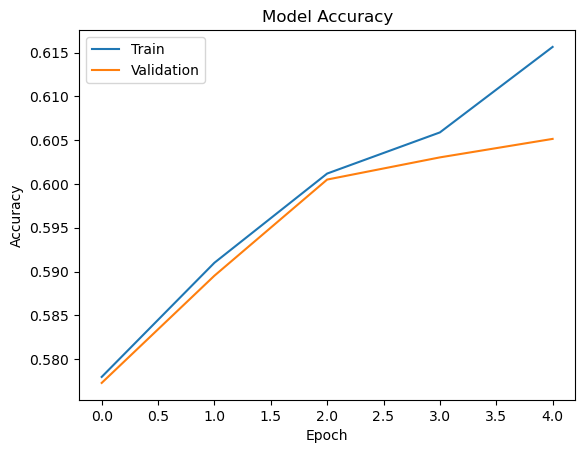

In [23]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

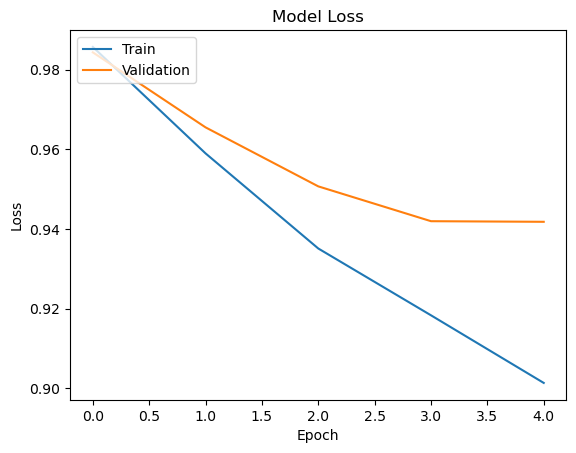

In [24]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

74/74 [==============================] - 60s 788ms/step


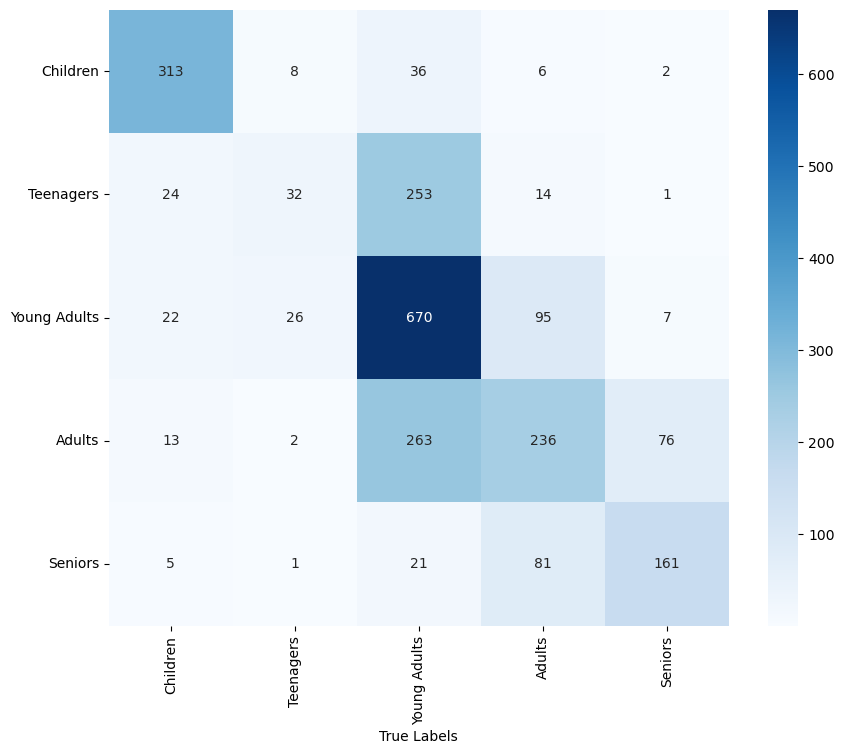

In [25]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_generator)

y_pred_classes = np.argmax(y_pred, axis = 1)

y_true = test_df_final["age_category_encoded"].values[:len(y_pred_classes)]

cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(cm, annot = True, fmt = "d", ax =ax, cmap = "Blues")
ax.set_xlabel("Predicted Labels")
ax.set_xlabel("True Labels")
ax.xaxis.set_ticklabels([reverse_age_mapping[i] for i in range(len(reverse_age_mapping))], rotation = 90)
ax.yaxis.set_ticklabels([reverse_age_mapping[i] for i in range(len(reverse_age_mapping))], rotation = 0)
plt.show()

# One-Off Accuracy

In [26]:
total_correct = 0
total_predictions = np.sum(cm)

#One-Off Accuracy
for i in range(len(cm)):
    total_correct += cm[i, i]

    if i > 0:
        total_correct += cm[i, i - 1]
    if i < len(cm) - 1:
        total_correct += cm[i, i + 1] 

one_off_accuracy = total_correct / total_predictions

print(f"One-Off Accuracy: {one_off_accuracy:.4f}")

One-Off Accuracy: 0.9451


# Gender-Race combination Confusion Matrix

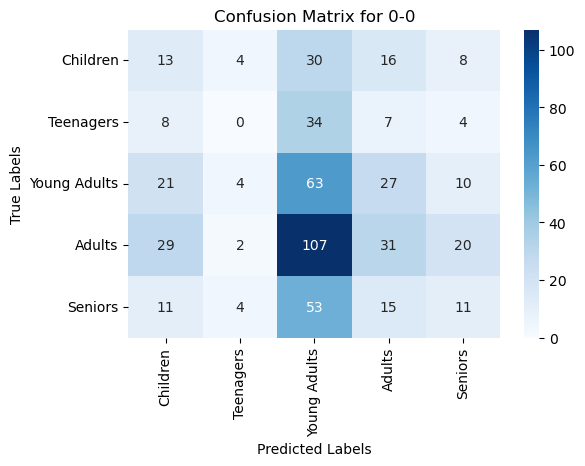

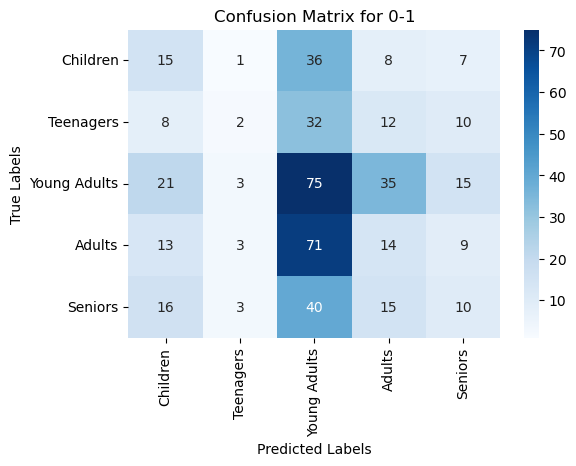

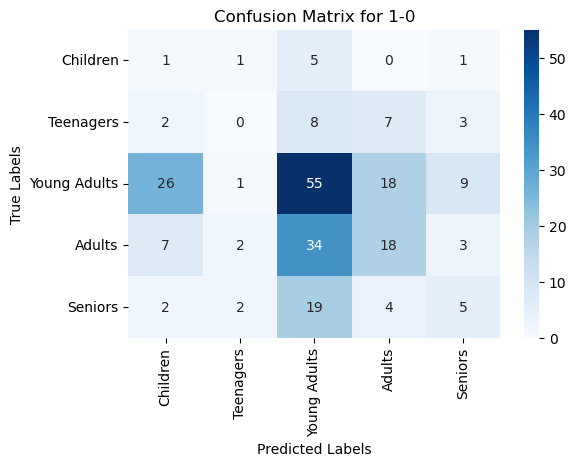

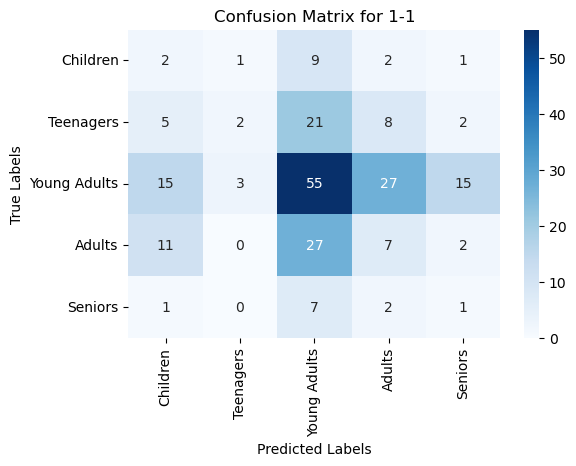

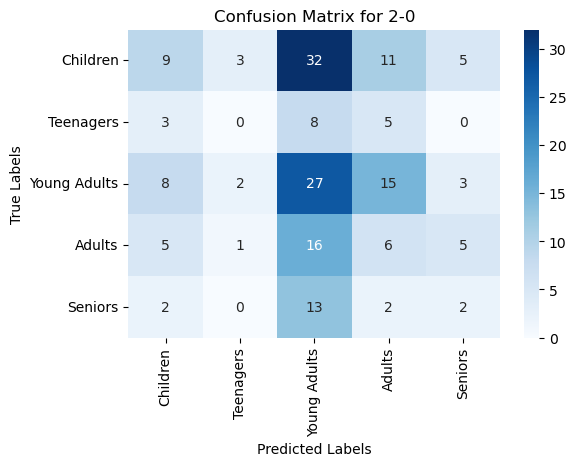

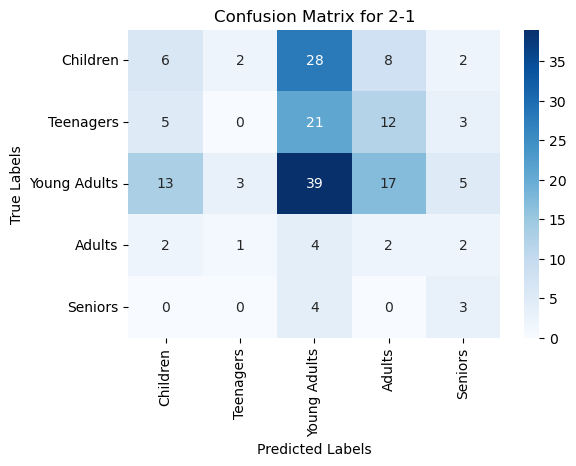

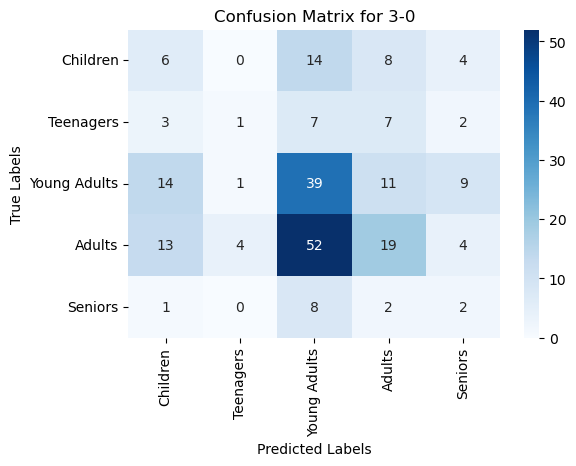

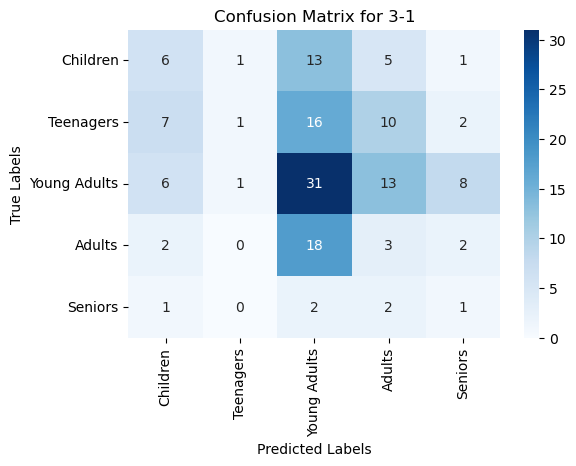

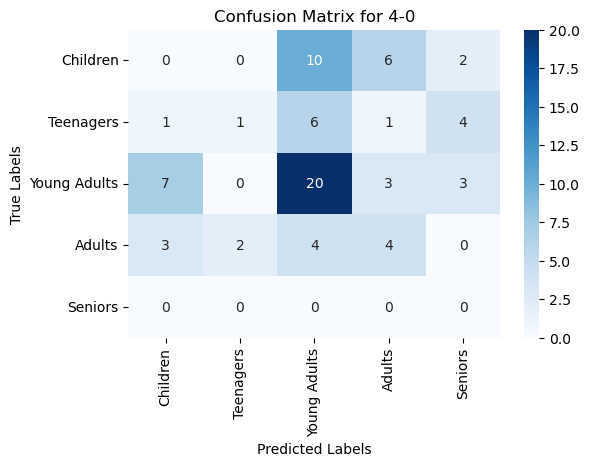

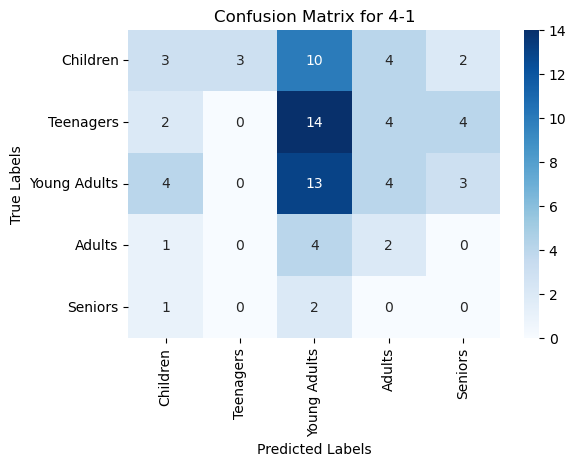

In [63]:
from sklearn.metrics import confusion_matrix

race_gender_pairs = test_df_final.groupby(['race', 'gender'])

# Creating confusion matrices for each race-gender pair
for (race, gender), group in race_gender_pairs:
    y_true_group = group['age_category_encoded'].values
    y_pred_group = y_pred_classes[:len(y_true_group)]  # Assuming predictions align with the true labels
    
    com = confusion_matrix(y_true_group, y_pred_group)
    
    # Plotting confusion matrix
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(com, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f"Confusion Matrix for {race}-{gender}")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.xaxis.set_ticklabels([reverse_age_mapping[i] for i in range(len(reverse_age_mapping))], rotation=90)
    ax.yaxis.set_ticklabels([reverse_age_mapping[i] for i in range(len(reverse_age_mapping))], rotation=0)
    plt.show()

* for classes like teenagers adults seniors, the model is not performing well
* the model outputs correctly the majority classes more often than minority classes

In [64]:
y_true = []
y_pred_classes = []

for _,batch in enumerate(test_generator):
    images, labels = batch
    preds = model.predict(images)
    y_true.extend(labels)
    y_pred_classes.extend(np.argmax(preds, axis  = 1))
    
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)


aligned_test_df = test_df_final.iloc[:len(y_true)]

1/1 [==============================] - 1s 822ms/step


In [65]:
from sklearn.metrics import classification_report

In [66]:
for race in aligned_test_df["race"].unique():
    for gender in aligned_test_df["gender"].unique(): 
        actual_race = reverse_race_mapping[race]
        actual_gender = reverse_gender_mapping[gender]
    
        subset_indices = aligned_test_df[(aligned_test_df["race"] == race) & (aligned_test_df["gender"] == gender) ].index
        valid_indices = subset_indices.intersection(range(len(y_true)))
        y_true_subset = y_true[valid_indices]
        y_pred_subset = y_pred_classes[valid_indices]
    
    
        print(f"classification report for Race : {actual_race}, Gender:  {actual_gender}")
        print(classification_report(y_true_subset, y_pred_subset, target_names = [reverse_age_mapping[i] for i in range(len(reverse_age_mapping))]))

classification report for Race : White, Gender:  Female
              precision    recall  f1-score   support

    Children       0.79      0.89      0.84        38
   Teenagers       0.20      0.03      0.05        36
Young Adults       0.51      0.81      0.63        94
      Adults       0.45      0.27      0.34        67
     Seniors       0.48      0.44      0.46        25

    accuracy                           0.54       260
   macro avg       0.49      0.49      0.46       260
weighted avg       0.49      0.54      0.49       260

classification report for Race : White, Gender:  Male
              precision    recall  f1-score   support

    Children       0.85      0.85      0.85        40
   Teenagers       0.56      0.16      0.24        32
Young Adults       0.62      0.91      0.73        97
      Adults       0.61      0.45      0.52        62
     Seniors       0.64      0.48      0.55        29

    accuracy                           0.65       260
   macro avg       0.

C:\Users\anoop\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anoop\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anoop\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* accuracy is not good for female